### lightGBM

### 電商銷量預估
目標:預測產品未來的銷量

流程:將資料整理合併order與deal，再以商品為單位，整理出產品相關特徵，並加上以種類為單位的銷售量週期(7天、14天、30天等)


###### order.csv
* columns:GUID(訂單編號) seller_GUID(廠商ID) subtotal(訂單金額) is_returned(是否退貨)create_time(訂購日期) business_hour_guid(商品檔次ID) order_from_type(來源裝置) user_id(訂購人ID) installment(刷卡分期)


###### deal.csv
* columns: business_hour_guid(商品檔次ID) seller_GUID(廠商ID),zip_code(供貨商郵遞區號),item_name(商品名稱),item_orig_price(原價),item_price(售價),item_default_daily_amount(上限),shopping_cart(是否為組合銷售),city_list(銷售頻道),deal_acc_business_group_id(事業群代號),deal_type_detail(商品子分類代號),code(google代號),is_travel_deal(是否為旅遊票券),installment_3months(信用卡可分3期),installment_6months(信用卡可分6期),installment_12months(信用卡可分12期),deny_installment(信用卡不可分期),shippingdate(配送天數),freight_amount(運費),discount_price(折扣後金額),is_wms(是否入倉)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re
pd.options.display.max_columns = 100


In [ ]:
order_ori =pd.read_csv("order.csv")
order_ori.rename(columns={'Unnamed: 4':'is_returned'}, inplace=True)
order_ori.head()

In [ ]:
deal=pd.read_csv("dealv2.csv")
deal=deal.reset_index()
deal

In [ ]:
deal.columns=['business_hour_guid', 'seller_GUID', 'business_hour_order_time_s',
       'business_hour_order_time_e', 'business_hour_deliver_time_s',
       'business_hour_deliver_time_e', 'pic_alt','zip_code', 'city_name',
       'district_name', 'item_name', 'item_orig_price', 'item_price',
       'item_default_daily_amount', 'event_name', 'event_title',
       'product_spec', 'shopping_cart', 'combo_pack_count',
       'quantity_multiplier', 'city_list', 'deal_acc_business_group_id',
       'acc_business_group_name', 'deal_type', 'is_travel_deal',
       'installment_3months', 'installment_6months', 'installment_12months',
       'deny_installment', 'shippingdate', 'is_long_contract',
       'develope_sales_id', 'operation_sales_id', 'slug', 'ordered_quantity',
       'ordered_total', 'category_list', 'freight_amount', 'enable_isp',
       'discount_price', 'is_wms', 'ancestor_business_hour_guid', 'code_name',
       'code']

In [ ]:
deal

In [ ]:
dfOri=pd.merge(order_ori,deal,how='left',on=['business_hour_guid','seller_GUID'])

In [ ]:
dfOri.to_csv('dfOri.csv',index=False)

### 將運送開始日期排序，找出有問題的欄位

In [3]:
dfOri=pd.read_csv("dfOri.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (14,23,24,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
dfOri.business_hour_deliver_time_e.sort_values(ascending= False).head(3)

3079467    9999-12-31 00:00:00.000
3081700    9999-12-31 00:00:00.000
3474924    9999-05-18 00:00:59.000
Name: business_hour_deliver_time_e, dtype: object

### 將異常欄位刪除

In [5]:
df=dfOri.drop(index=[3079467,3081700,3474924])

### 重複值

In [5]:
dfOri.shape

(4080857, 52)

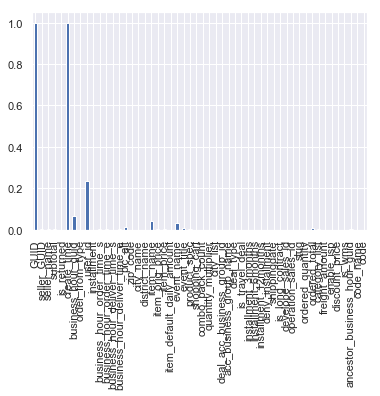

In [6]:
(dfOri.apply(lambda x:x.unique().shape[0],axis=0)/dfOri.shape[0]).plot(kind='bar')

### 遺漏值

In [ ]:
tempdfg=dfOri[['pic_alt', 'zip_code', 'city_name',
       'district_name', 'item_name', 'item_orig_price', 'item_price',
       'item_default_daily_amount', 'event_name', 'event_title',
       'product_spec', 'shopping_cart', 'combo_pack_count',
       'quantity_multiplier', 'city_list', 'deal_acc_business_group_id',
       'acc_business_group_name', 'deal_type', 'is_travel_deal',
       'installment_3months', 'installment_6months', 'installment_12months',
       'deny_installment', 'shippingdate', 'is_long_contract',
       'develope_sales_id', 'operation_sales_id', 'slug', 'ordered_quantity',
       'ordered_total', 'category_list', 'freight_amount', 'enable_isp',
       'discount_price', 'is_wms', 'ancestor_business_hour_guid', 'code_name']]
tempdfg.isnull().sum().plot(kind='bar',title='number of missing values')

___

#### 商品特徵欄位
--檔期接續問題
--計算時間問題
##### 目前已可取得：
* 商品ID V
* 品牌：將不同品牌使用Label Encoding 加以標示
* 關鍵字：先挑出根據出現詞頻最高的5~10個行銷用詞(如：熱銷、買_送_...等)，再計算每個商品標題中含有行銷用詞之次數(或將其分等級)
* 品類：從order檔案與deal檔案結合	
* 促銷與否：結合discount檔案，看其商品是否有加入促銷活動(1 or 0) 豪仔
* 分期：計算該商品是否有提供分期付款優惠(3,6,12) V
* 配送時間：V
* 上架月份：利用business_hour_order_time_s找出檔次上架之月份(若為累積檔次取其出現頻率最多者)V
* 上架星期：利用business_hour_order_time_s找出該天為星期幾(若為累積檔次取其出現頻率最多者) V
* 上架時間：利用business_hour_order_time_s找出上架時間點(以24小時為欄位) V
* 檔期長度(天數)：利用business_hour_order_time_s、business_hour_order_time_e欄位相減	(可先做) V
* 是否為長銷型商品
* 開賣前三天的銷量:利用order訂單與business_hour_order_time_s時間相減進行計算 V
* 是否預購：計算訂購與配送之時間差(若超過三週則設為預購，以1,0劃分) (可先做)V
* 與同類商品的單位價格中位數比較：計算該產品的產品單位價格中位數，與其單位價格比較(使用百分比)
* 熱銷：觀察該商品上過熱銷排行榜的次數(用整個平台的每日銷量，判斷是否有為全平台的Top20)再除以檔期長度 取百分比
* 可超取：可否超商取貨 V
* 單位價格（單一檔期)	
* 總銷售量 (單一檔期)
* 商品平均價格(全檔期)
* 總銷售量(全檔期)
* 該品類最高銷售量商品(單一檔期)待定
* 該品類最高銷售量商品(全檔期)待定

--消費熱衷區間、了解消費者pattern
#### 目標變數：
* 該商品於未來7.14.30.60.180天的預估銷量：利用order訂單與business_hour_order_time_s時間相減進行計算，除以總銷量取得百分比(可先做)


### 將欄位轉換格式為datetime

In [6]:
import datetime

In [7]:

df=df.reset_index(drop=True)
df=df[:4080853]

In [8]:
for i in ['business_hour_order_time_s','create_time','business_hour_order_time_e','business_hour_deliver_time_s','business_hour_deliver_time_e']:
        df[i]=pd.to_datetime(df[i])
    

### 取出檔期開始之月份 時間點 星期幾 檔次長度 訂購與開始運送之天數差(用來計算是否有預購情況)

In [9]:
df['product_launch_month']=df['business_hour_order_time_s'].apply(lambda x:x.month)
df['product_launch_hour']=df['business_hour_order_time_s'].apply(lambda x:x.hour)
df['product_launch_weekday']=df['business_hour_order_time_s'].apply(lambda x:x.weekday())
df['campagin_period']=(df['business_hour_order_time_e']-df['business_hour_order_time_s']).apply(lambda x:x.days)
df['order_deliver_days']=(df['business_hour_deliver_time_s']-df['business_hour_order_time_s']).apply(lambda x : x.days )

In [10]:
def trans(x):
    if x>=3:
        return 1
    elif x<3:
        return 0
    else:
        return np.NaN

df["presales"]=df['order_deliver_days'].apply(trans)
df['purchase_year']=df['create_time'].apply(lambda x:x.year)


##  挑選 2015~2019間的交易紀錄，約有2,126,469筆交易紀錄

In [11]:
df=df[df.purchase_year>=2015]

In [15]:
df.shape

(2126469, 59)

In [12]:
df.head()

,GUID,seller_GUID,seller_name,subtotal,is_returned,create_time,business_hour_guid,order_from_type,user_id,installment,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,item_name,item_orig_price,item_price,item_default_daily_amount,event_name,event_title,product_spec,shopping_cart,combo_pack_count,quantity_multiplier,city_list,deal_acc_business_group_id,acc_business_group_name,deal_type,is_travel_deal,installment_3months,installment_6months,installment_12months,deny_installment,shippingdate,is_long_contract,develope_sales_id,operation_sales_id,slug,ordered_quantity,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,product_launch_month,product_launch_hour,product_launch_weekday,campagin_period,order_deliver_days,presales,purchase_year
1954384,3499C728-7CC4-46B4-8FDD-B47AF84DB483,5616D8B6-BB05-45DB-8408-04320DD6E48E,台灣晟龍國際科技有限公司,205.0,0.0,2015-01-01 00:00:15.960,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,2.0,1.112997e+09,0.0,2014-12-31 12:00:00,2015-01-14 12:00:00,2014-12-31,2015-01-23,手機殼,234.0,新北市,永和區,閃閃手工水鑽系列手機皮套機殼-時尚奢華風（任選1入方案）,790.0,205.0,20.0,宅配：只要205元(含運)即可帶走原價790元閃閃手工水鑽系列手機皮套機殼-時尚奢華風任選1...,NaN,NaN,1.0,1.0,NaN,[477],7.0,宅配,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112804e+09,1.112804e+09,46.0,46.0,9430.0,[],0.0,0.0,NaN,0.0,NaN,電腦/平板/手機配件,2082.0,12,12,2,14,-1,0,2015
1954385,01B850AD-5D61-4FBC-9D9C-6722BF966B9E,BC825B7E-9962-4E3C-A16F-5FB2E64B0C71,欣康有限公司(Osun),1090.0,1.0,2015-01-01 00:01:20.717,EFBA954B-B665-4FF1-B4ED-857B915FB840,1.0,1.112209e+09,0.0,2014-12-31 12:00:00,2015-01-21 12:00:00,2014-12-31,2015-01-22,沙發套,220.0,新北市,板橋區,Osun-一體成型防蟎彈性沙發套組共享三人座,2480.0,1090.0,20.0,宅配：只要1090元(含運)即可購得【Osun】原價2480元一體成型防蟎彈性沙發套組共享三...,NaN,NaN,1.0,1.0,NaN,[477|491],7.0,宅配,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112453e+09,1.112453e+09,30.0,27.0,29430.0,[],0.0,0.0,NaN,0.0,NaN,生活百貨/衛浴設備用品,536.0,12,12,2,21,-1,0,2015
1954386,0B3455D8-25C1-4100-8159-76D00832965F,59E80524-8DE5-4FD2-931F-99400B600BBC,買新鮮科技股份有限公司,596.0,0.0,2015-01-01 00:01:54.760,48FF7620-2D38-4673-A012-30EC61C40065,2.0,1.111958e+09,0.0,2014-12-29 19:20:00,2015-01-06 12:00:00,2014-12-29,2015-01-07,買新鮮/法式櫻桃鴨胸,236.0,新北市,土城區,買新鮮-黑胡椒蜜燻鴨胸1份方案,300.0,149.0,20.0,宅配：只要149元(4份免運)即可帶走【買新鮮】原價300元黑胡椒蜜燻鴨胸1份( 200g±...,營養豐富、嫩口好吃的煙燻黑胡椒鴨胸|粉色肉質多汁鮮美|中西料理皆可行|享受美味的五星級佳餚不用等！,NaN,0.0,1.0,1.0,[477|491],7.0,宅配,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112763e+09,1.112763e+09,33.0,33.0,4917.0,[],150.0,0.0,NaN,0.0,NaN,生鮮/肉品/蛋,432.0,12,19,0,7,-1,0,2015
1954387,DD7F5BF7-798A-46EF-80CC-C771E201BB3F,610916CA-8497-4E88-A06D-825508B775D3,彩國貿易股份有限公司,398.0,0.0,2015-01-01 00:02:23.180,33012183-5329-4C92-B0C9-3D2FE3BA316A,6.0,1.111623e+09,0.0,2014-12-31 12:00:00,2015-01-10 12:00:00,2014-12-31,2015-01-14,蕾絲/背心/運動內衣,632.0,雲林縣,虎尾鎮,蕾絲零束縛內衣薄款背心式無鋼圈運動睡眠內衣（2件方案）,1998.0,398.0,20.0,宅配：只要398元(免運)即可帶走原價1998元蕾絲零束縛內衣薄款背心式無鋼圈運動睡眠內衣2...,3D無感舒適美背內衣|吸汗透氣|潔淨乾爽|超寬肩帶|無鋼圈設計|運動、休閒、居家零束縛|專為...,NaN,1.0,2.0,2.0,[477|492],7.0,宅配,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112546e+09,1.112546e+09,52.0,52.0,20696.0,[],0.0,0.0,NaN,0.0,NaN,居家服/內睡衣著,166.0,12,12,2,10,-1,0,2015
1954388,AC51D435-56BB-4279-9B0C-071052A53FE0,E92751C8-2D91-43EC-AF40-72804365A000,最愛百貨商行,1398.0,0.0,2015-01-01 00:03:18.153,39713041-01D7-4402-97FB-C361A6C68E95,3.0,1.112663e+09,0.0,2014-12-31 12:00:00,2015-01-01 12:00:00,2014-12-31,2015-01-09,韓版/外套,801.0,高雄市,前金區,韓系長版修身保暖羽絨棉外套（2件方案）,3960.0,1398.0,20.0,宅配：只要1398元(含運)即可帶回原價3960元韓系長版修身保暖羽絨棉外套2件|多款多色可...,NaN,NaN,1.0,2.0,2.0,[477],7.0,宅配,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.112236e+09,1.112236e+09,107.0,80.0,111840.0,[],0.0,0.0,NaN,0.0,NaN,時尚鞋包,166.0,12,12,2,1,-1,0,2015


In [13]:
df.to_csv("df.csv",index=False)

In [16]:
df=pd.read_csv("df.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 找出商品檔次繼承關係

* 刪除重複檔次ID

In [17]:
tempdf=df[['business_hour_guid','ancestor_business_hour_guid']].drop_duplicates(['business_hour_guid'])

## 建立查詢字典

In [18]:
##將兩欄位位置對調，更名(改名為檔次1,2...)
bhgnoNaN=tempdf[tempdf.ancestor_business_hour_guid.isnull()==False]
dictionary=bhgnoNaN[["ancestor_business_hour_guid","business_hour_guid"]]
dictionary=dictionary.rename(columns={'ancestor_business_hour_guid':'business_hour_guid','business_hour_guid':'business_hour_guid_1'})
dictionary.head()

,business_hour_guid,business_hour_guid_1
107,1D0E4ADA-E0FE-497D-BD67-F0FF54646230,9059790B-2031-40B5-A13D-CBEB23E8E404
119,6A264CC8-8961-4EB7-A278-B2E3574021DC,CDE6DE0D-8DE2-4932-8C7A-D3E1A11DBE9D
237,CD4996CB-9359-4ADB-94CD-302480758DCE,D28C81C0-B921-44E5-B928-83AF938FE10C
348,3F5BCC0C-F6C7-4102-AC0F-4667C3C61BAE,D88A2E45-8A21-44AD-B32E-E40DB28291A7
408,F8E8FD06-4E2C-4C55-9794-2FD424266D31,6DD9A829-B253-4143-92AC-1004CBF40B33


* 先找出檔次ID與前次檔次ID，將已無前檔次ID的檔次作為開頭表格(ancestor_business_hour_guid.isnull()==True)

In [19]:
bhgwithNaN=tempdf[tempdf.ancestor_business_hour_guid.isnull()==True]
bhgwithNaN=bhgwithNaN[['business_hour_guid']]
tmp=pd.merge(bhgwithNaN,dictionary,how="left")
tmp.head()

,business_hour_guid,business_hour_guid_1
0,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,NaN
1,EFBA954B-B665-4FF1-B4ED-857B915FB840,NaN
2,48FF7620-2D38-4673-A012-30EC61C40065,NaN
3,33012183-5329-4C92-B0C9-3D2FE3BA316A,NaN
4,39713041-01D7-4402-97FB-C361A6C68E95,NaN


In [20]:
##沒有前次檔期的商品後面就會顯示NaN,商品最多有17個檔期
i=1
while True:
    dictcol1='business_hour_guid_'+str(i)
    dictcol2='business_hour_guid_'+str(i+1)
    dictionary.columns=[dictcol1,dictcol2]
    tmp=pd.merge(tmp,dictionary,how="left")
    print(tmp[tmp[dictcol2].isnull()==False].shape)
    if(tmp[dictcol2].isnull().all()==True):
        break
    else:
        i=i+1

(727, 3)
(497, 4)
(341, 5)
(235, 6)
(158, 7)
(116, 8)
(92, 9)
(75, 10)
(59, 11)
(34, 12)
(22, 13)
(14, 14)
(10, 15)
(5, 16)
(3, 17)
(0, 18)


In [21]:
tmp['list']=tmp.apply(lambda x: x.tolist(), axis=1)
tmp

,business_hour_guid,business_hour_guid_1,business_hour_guid_2,business_hour_guid_3,business_hour_guid_4,business_hour_guid_5,business_hour_guid_6,business_hour_guid_7,business_hour_guid_8,business_hour_guid_9,business_hour_guid_10,business_hour_guid_11,business_hour_guid_12,business_hour_guid_13,business_hour_guid_14,business_hour_guid_15,business_hour_guid_16,business_hour_guid_17,list
0,B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[B744DFF8-0D8F-49E1-A6AA-536DBD4CCE8B, nan, na..."
1,EFBA954B-B665-4FF1-B4ED-857B915FB840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[EFBA954B-B665-4FF1-B4ED-857B915FB840, nan, na..."
2,48FF7620-2D38-4673-A012-30EC61C40065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[48FF7620-2D38-4673-A012-30EC61C40065, nan, na..."
3,33012183-5329-4C92-B0C9-3D2FE3BA316A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[33012183-5329-4C92-B0C9-3D2FE3BA316A, nan, na..."
4,39713041-01D7-4402-97FB-C361A6C68E95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[39713041-01D7-4402-97FB-C361A6C68E95, nan, na..."
5,B7ED6368-B1CF-4B6F-BA09-033ED04414E3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[B7ED6368-B1CF-4B6F-BA09-033ED04414E3, nan, na..."
6,F92B1A31-F411-4B4B-8B7F-2317CC665F7B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[F92B1A31-F411-4B4B-8B7F-2317CC665F7B, nan, na..."
7,BCC8D514-2409-476F-81CB-88EC7451FF01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[BCC8D514-2409-476F-81CB-88EC7451FF01, nan, na..."
8,08641E7A-4BBA-42D5-B270-046F1619B7CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[08641E7A-4BBA-42D5-B270-046F1619B7CD, nan, na..."
9,3311B9BC-C422-4E76-AD11-6552D2DB5B9F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[3311B9BC-C422-4E76-AD11-6552D2DB5B9F, nan, na..."


### List中 去除空值

In [22]:
def delNaN(x):
    cleanedList = [i for i in x if str(i) != 'nan']
    return cleanedList
tmp['list']=tmp['list'].apply(delNaN)

In [23]:
tmp['present_guid']=tmp['list'].apply(lambda x:x[-1])

In [24]:
tmp.to_csv("guid_rela.csv",index=False)

In [6]:
tmp=pd.read_csv("guid_rela.csv")

In [25]:
###排序
tmpo=tmp.sort_values(by=['list']).reset_index(drop=True)

In [37]:
tmpo[tmpo.business_hour_guid_15.isnull()==False]

,business_hour_guid,business_hour_guid_1,business_hour_guid_2,business_hour_guid_3,business_hour_guid_4,business_hour_guid_5,business_hour_guid_6,business_hour_guid_7,business_hour_guid_8,business_hour_guid_9,business_hour_guid_10,business_hour_guid_11,business_hour_guid_12,business_hour_guid_13,business_hour_guid_14,business_hour_guid_15,business_hour_guid_16,business_hour_guid_17,list,present_guid
4633,058D4E18-CB19-4501-93B9-AC175BA53E14,1530B0CD-F56E-4A2C-ACE5-B53885C58BD1,55118BB2-845E-4F56-8CF8-A900A8BF657F,A0834644-FA8D-44A9-BB75-C2A7BFD80132,33CAD8C9-A37E-48E1-8BD9-3405728CE712,2F29AA6C-AC40-46A8-AD55-54706CDB5475,2F466A4C-66CE-47D9-97C8-933E606C0044,64D820E0-9BCC-4BA0-AE15-1EBAB4E6F9F9,577B8EC8-7940-4C15-9699-9707F9040743,6E0EFC90-8B30-4B73-9976-186C5BC7CF0E,46286746-2BD9-459F-B071-B30E7093C536,2A5D4E0D-008C-4E65-91EB-7C811DED472B,6A731A14-E4C5-4682-BE5D-A6C29757A0A3,F7E36018-CCA5-4A2F-959E-59EAE0269F05,0AD7CA1C-34B1-4DB0-BA94-7B6F6581C13C,5BCB232D-3F5B-4874-9A90-117307A6229C,NaN,NaN,"[058D4E18-CB19-4501-93B9-AC175BA53E14, 1530B0C...",5BCB232D-3F5B-4874-9A90-117307A6229C
4634,058D4E18-CB19-4501-93B9-AC175BA53E14,1530B0CD-F56E-4A2C-ACE5-B53885C58BD1,55118BB2-845E-4F56-8CF8-A900A8BF657F,A0834644-FA8D-44A9-BB75-C2A7BFD80132,33CAD8C9-A37E-48E1-8BD9-3405728CE712,2F29AA6C-AC40-46A8-AD55-54706CDB5475,2F466A4C-66CE-47D9-97C8-933E606C0044,64D820E0-9BCC-4BA0-AE15-1EBAB4E6F9F9,577B8EC8-7940-4C15-9699-9707F9040743,6E0EFC90-8B30-4B73-9976-186C5BC7CF0E,46286746-2BD9-459F-B071-B30E7093C536,2A5D4E0D-008C-4E65-91EB-7C811DED472B,6A731A14-E4C5-4682-BE5D-A6C29757A0A3,F7E36018-CCA5-4A2F-959E-59EAE0269F05,0AD7CA1C-34B1-4DB0-BA94-7B6F6581C13C,6884C1AA-84FB-47F4-93A5-A608382505DB,NaN,NaN,"[058D4E18-CB19-4501-93B9-AC175BA53E14, 1530B0C...",6884C1AA-84FB-47F4-93A5-A608382505DB
12566,0EF49AC5-BAE8-49FD-BC77-FE2A3F19D823,345152B3-DDB9-453B-9629-66BA8BE19FD0,D298F08C-42DB-4988-AA3D-A9F188C08B61,87CB65A3-DC83-4FFB-9477-FF2D02E53DF1,D8B91539-BEBC-4691-9FB4-EBE48C3B94F2,15160AC2-F9E1-4712-97A5-260453B7D19E,4E27DFD9-6FD9-4F89-AE06-C9E59E2F88D1,C8B8262E-7E6E-401F-ADFA-DE54354EB168,6705A088-1FF3-4256-A732-33CE207EF64B,752104CE-2F0B-4849-B8B3-C4C0450FBFF8,5939591E-4587-4419-AF5E-9B9A48A90193,E579A31B-6F4F-459C-A851-300209E90636,6597C753-C879-4D0C-AF46-DC0D25643AED,57151D66-5FB3-49FA-980E-DDF533C0FA63,AA91ACD3-53A8-4789-BF7F-78B8B7274FBE,F7B236E7-AECD-4CDA-AF15-D7DE254E3B2B,5FE0C5B7-E922-4ACB-869A-1745AAB2E8D9,NaN,"[0EF49AC5-BAE8-49FD-BC77-FE2A3F19D823, 345152B...",5FE0C5B7-E922-4ACB-869A-1745AAB2E8D9
12567,0EF49AC5-BAE8-49FD-BC77-FE2A3F19D823,345152B3-DDB9-453B-9629-66BA8BE19FD0,D298F08C-42DB-4988-AA3D-A9F188C08B61,87CB65A3-DC83-4FFB-9477-FF2D02E53DF1,D8B91539-BEBC-4691-9FB4-EBE48C3B94F2,15160AC2-F9E1-4712-97A5-260453B7D19E,4E27DFD9-6FD9-4F89-AE06-C9E59E2F88D1,C8B8262E-7E6E-401F-ADFA-DE54354EB168,6705A088-1FF3-4256-A732-33CE207EF64B,752104CE-2F0B-4849-B8B3-C4C0450FBFF8,5939591E-4587-4419-AF5E-9B9A48A90193,E579A31B-6F4F-459C-A851-300209E90636,6597C753-C879-4D0C-AF46-DC0D25643AED,57151D66-5FB3-49FA-980E-DDF533C0FA63,AA91ACD3-53A8-4789-BF7F-78B8B7274FBE,F7B236E7-AECD-4CDA-AF15-D7DE254E3B2B,6D3D365D-1DE2-40A6-A670-114BAC1E0125,NaN,"[0EF49AC5-BAE8-49FD-BC77-FE2A3F19D823, 345152B...",6D3D365D-1DE2-40A6-A670-114BAC1E0125
97089,75469787-0C68-4312-A599-CAF2C4048634,1083947A-AD1A-47FF-9DAD-E615EC421588,2F86E560-044E-4CFA-86B1-151691163003,7E412BD7-5415-4157-908E-81EAAD12000E,5ADA672C-D498-44D5-A477-07800CACED1F,60704D1A-A495-41F6-9F16-EB75B8671266,2A973A33-7DF6-42FD-8050-607EBD9FB202,2BA75F94-C7A4-4765-8AF6-A81E84E4FFC5,1329B73B-3EA7-4731-9791-C690268B85E1,F475715D-14D7-4D70-9059-33D2E3B15586,F1C11B35-2F47-4373-A5F8-833C72A87FE5,ABE9F8A0-154A-4161-BECA-400861C33D25,5A8E36AE-0275-4451-A895-CC63A60EAE19,73EB554B-17E0-4495-B88F-DA8876F70EBD,BA2C6017-753A-4669-BC3B-E26EFC4B36ED,D5A25EF5-EC21-4D25-81DD-C0E29A9CD6EB,NaN,NaN,"[75469787-0C68-4312-A599-CAF2C4048634, 1083947...",D5A25EF5-EC21-4D25-81DD-C0E29A9CD6EB
112784,887731BB-EFCF-4D84-A3E4-1E43F43ECDEA,295E0A27-7739-